In [17]:
from os.path import join
from os import getcwd
from tensorflow import keras
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.optimizers.schedules import ExponentialDecay
from keras.initializers import GlorotNormal
from keras.regularizers import l1, l2

In [5]:
from functions import *
checkpoints_path = getcwd()+'\\checkpoints'

In [6]:
df = pd.read_csv('../../databases/insurance.csv')
x_df = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
y_df = df['charges']
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
x_df_edit = x_df.copy()
replace = {
    'sex': {'female':1, 'male':0},
    'smoker':{'yes':1, 'no':0}
}
x_df_edit = x_df_edit.replace(replace)
x_df_edit.head()

,age,sex,bmi,children,smoker,region
0,19,1,27.900,0,1,southwest
1,18,0,33.770,1,0,southeast
2,28,0,33.000,3,0,southeast
3,33,0,22.705,0,0,northwest
4,32,0,28.880,0,0,northwest


In [9]:
x_df_encoded = pd.get_dummies(x_df_edit, columns=['region'])
x_df_encoded.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,0,0,0,1
1,18,0,33.770,1,0,0,0,1,0
2,28,0,33.000,3,0,0,0,1,0
3,33,0,22.705,0,0,0,1,0,0
4,32,0,28.880,0,0,0,1,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


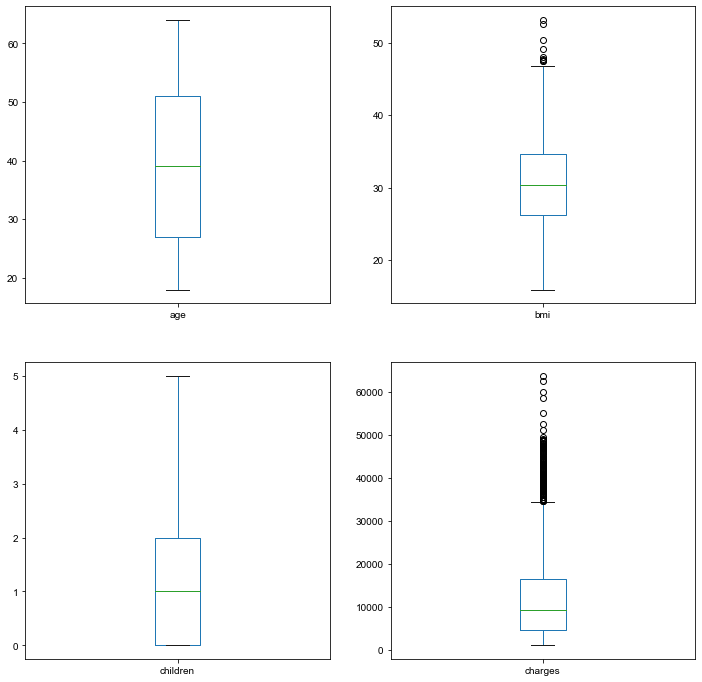

In [18]:
df.plot(kind= 'box' , subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(12,12))
sns.set(font_scale = 1.5)

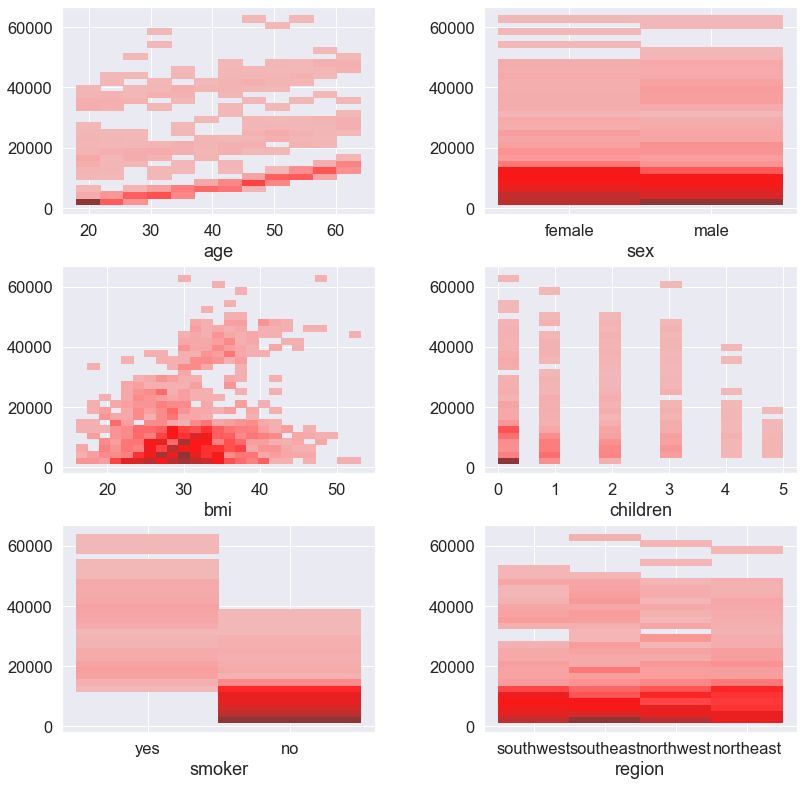

In [34]:
plt.subplots(3, 2, figsize=(12,12))
for i, col in enumerate(x_df.columns):
    plt.subplot(3, 2, i+1)
    a = sns.histplot(x=df[col],y=y_df, label='charged', color='red')
    a.set(ylabel=None)    

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)

<AxesSubplot:>

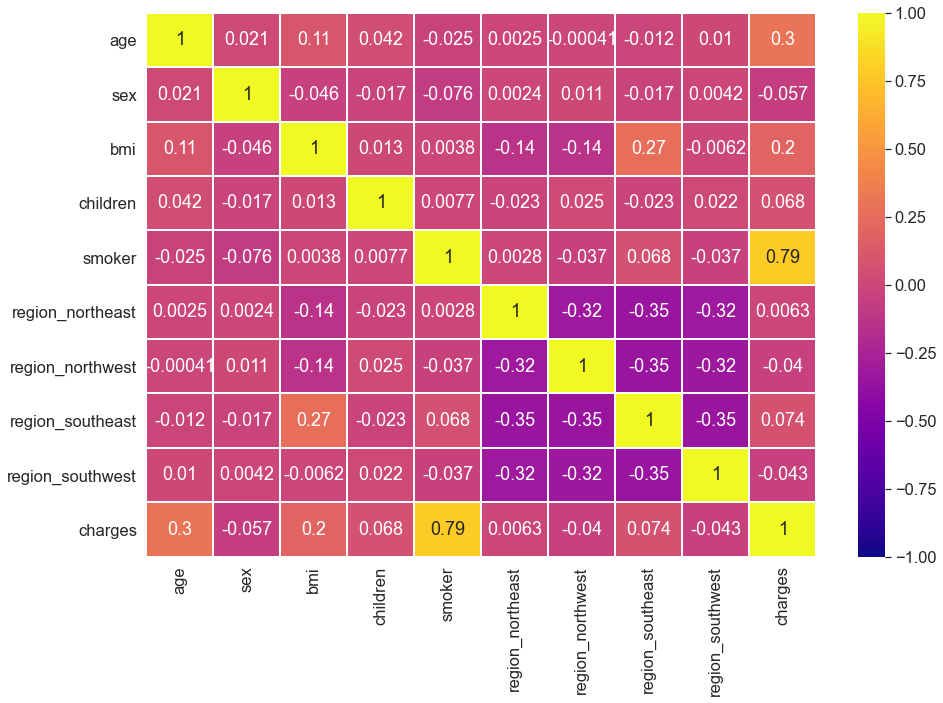

In [27]:
df_encoded=x_df_encoded.copy()
df_encoded['charges']=y_df
corr=df_encoded.corr()
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.5)
sns.heatmap(corr, annot = True, cmap = 'plasma', vmin = -1, vmax = 1, linecolor='white', linewidths= 1)

In [37]:
# Split dataset into 15% test, 85% train_validation 
x, x_test, y, y_test = train_test_split(x_df_encoded, y_df, test_size=0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.15, random_state=1)

In [50]:
model_0 = Sequential()
model_0.add(Dense(units=1, activation='relu', input_shape=(x_train.shape[1],)))
model_0.compile(optimizer=SGD(), loss='mae', metrics=[[keras.metrics.MeanAbsoluteError()]])

In [51]:
model_0_checkpoint_callback = ModelCheckpoint(
    filepath=join(checkpoints_path, 'basic'),
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_best_only=True)

In [52]:
%%time
history = model_0.fit(x_train, y_train, epochs=50, 
            validation_data=(x_valid, y_valid),
            callbacks=[model_0_checkpoint_callback],
            verbose=0)
# Cargo el mejor modelo entrenado
model_0.load_weights(join(checkpoints_path, 'basic'))
verify_model(model_0, x_train, y_train, x_valid, y_valid)

Wall time: 5.89 s


,Set,MAE,MSE
0,Train,"(tf.Tensor(12277.648, shape=(), dtype=float32)...","(tf.Tensor(300530200.0, shape=(), dtype=float3..."
1,Validacion,"(tf.Tensor(12648.564, shape=(), dtype=float32)...","(tf.Tensor(298563780.0, shape=(), dtype=float3..."


### Regresion lineal